# [DNN]-[Wine] Wine quality prediction with a Dense Network (DNN)

This Kaggle notebook provides a step-by-step implementation of a simple prediction task using dense neural network (DNN) on the popular Wine Quality dataset.

The [Wine Quality datasets](https://archive.ics.uci.edu/ml/datasets/wine+Quality) consist of analyses of a large number of wines, each with an associated quality score ranging from 0 to 10. The dataset was provided by:
- Paulo Cortez, University of Minho, Guimarães, Portugal, http://www3.dsi.uminho.pt/pcortez
- A. Cerdeira, F. Almeida, T. Matos, and J. Reis, Viticulture Commission of the Vinho Verde Region (CVRVV), Porto, Portugal, @2009

You can retrieve the dataset from [University of California Irvine (UCI)](https://archive-beta.ics.uci.edu/ml/datasets/wine+quality).

Due to privacy and logistical concerns, only physicochemical and sensory variables are available in the dataset. Information such as grape types, wine brands, and selling prices is not included. The dataset features the following variables:
- Fixed acidity
- Volatile acidity
- Citric acid
- Residual sugar
- Chlorides
- Free sulfur dioxide
- Total sulfur dioxide
- Density
- pH
- Sulphates
- Alcohol
- Quality (score between 0 and 10)

The notebook is organized into three distinct sections:

## Objectives:
- Predict the quality of wines based on analysis data.

## Steps:
1. **Imports & Constants & Methods**
2. **Retrieve the data:** Obtain the wine quality dataset from the provided source.
3. **Prepare the data:** Perform necessary preprocessing and cleaning of the dataset.
4. **Build a model:** Design and construct a dense neural network (DNN) model for wine quality prediction.
5. **Train and save the model:** Train the DNN model using the prepared dataset and save the trained model for future use.
6. **Evaluate the model:** Assess the performance of the trained model by evaluating its predictions on test data.
7. **Evaluate the best saved model:** Assess the performance of the trained bast model saved by the callback, by evaluating its predictions on test data.
8. **Make predictions:** Apply the on the best trained model to make predictions on new, unseen wine data.

## 1. Imports & Constants & Methods

### 1.1. Imports

In [15]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

!pip install visualkeras

import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 15.1 MB/s eta 0:00:00a 0:00:01


Verbosity during training:
- 0: Silent mode, no output will be displayed during training.
- 1: Progress bar mode, a progress bar will be displayed to show the progress of each epoch.
- 2: One line per epoch mode, a concise summary will be displayed for each epoch.

--For the current training configuration:
-- Batch size: 512, which determines the number of samples processed in each training iteration.
-- Number of epochs: 16, indicating the total number of times the model will be trained on the entire dataset.


### 1.2. Constants

In [2]:
fit_verbosity = 1
dataset_path  = '/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'

### 1.3. Methods

In [30]:
def show_history(
    history, 
    figsize=(8,6), 
    plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']}
):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        plt.show()
        
        
def show_confusion_matrix(
    y_true,
    y_pred,
    target_names,
    title='Confusion matrix',
    cmap=None,
    normalize=True,
    figsize=(10, 8),
    digit_format='{:0.2f}'
):
    cm = sklearn.metrics.confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## 2.Retrieve data

In [5]:
data = pd.read_csv(dataset_path, header=0,sep=',')

display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5.00
1,7.80,0.88,0.00,2.60,0.10,25.00,67.00,1.00,3.20,0.68,9.80,5.00
2,7.80,0.76,0.04,2.30,0.09,15.00,54.00,1.00,3.26,0.65,9.80,5.00
3,11.20,0.28,0.56,1.90,0.07,17.00,60.00,1.00,3.16,0.58,9.80,6.00
4,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5.00


Missing Data :  0   Shape is :  (1599, 12)


## 3. Preparing the data

### 3.1. Splitting the data

To prepare the data for training and validation, we will split it into two parts: 80% for training and 20% for validation. 

The feature data, representing the analysis variables, will be denoted as 'x', while the target variable, indicating the wine quality, will be denoted as 'y'.

In [10]:
# train, test
#
data = data.sample(frac=1., axis=0)           # Shuffle
data_train = data.sample(frac=0.8, axis=0)    # get 80%
data_test = data.drop(data_train.index)       # test = all - train

# x, y (quality is the target variable)
#
x_train = data_train.drop('quality', axis=1)
y_train = data_train['quality']
x_test = data_test.drop('quality', axis=1)
y_test = data_test['quality']
shape = x_train.shape[1]

print('Original data shape was:', data.shape)
print('x_train:', x_train.shape, 'y_train:', y_train.shape)
print('x_test:', x_test.shape, 'y_test:', y_test.shape)
print('Shape:', shape)

Original data shape was: (1599, 12)
x_train: (1279, 11) y_train: (1279,)
x_test: (320, 11) y_test: (320,)
Shape: 11


### 3.2. Data normalization

**Note:**
- It is important to normalize all input data, including both the training and testing datasets.
- For normalization, we will subtract the mean and divide by the standard deviation.
- However, it is crucial to avoid using the test data for any calculations, including normalization.
- Therefore, the mean and standard deviation will only be calculated based on the training data.

In [11]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()

x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

# Convert ou DataFrame to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,8.32,0.53,0.27,2.54,0.09,15.94,46.53,1.00,3.31,0.66,10.42
std,1.73,0.18,0.19,1.45,0.05,10.62,33.29,0.00,0.16,0.17,1.08
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40
25%,7.10,0.39,0.10,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,1.00,3.31,0.62,10.10
75%,9.30,0.64,0.42,2.60,0.09,22.00,62.00,1.00,3.40,0.73,11.10
max,15.90,1.58,1.00,15.50,0.61,72.00,289.00,1.00,4.01,2.00,14.90


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.15,-2.26,-1.41,-1.13,-1.57,-1.41,-1.22,-3.54,-3.63,-1.89,-1.88
25%,-0.71,-0.77,-0.91,-0.44,-0.36,-0.84,-0.74,-0.61,-0.64,-0.62,-0.86
50%,-0.24,-0.05,-0.06,-0.24,-0.18,-0.18,-0.26,0.00,-0.01,-0.22,-0.30
75%,0.57,0.61,0.77,0.04,0.05,0.57,0.46,0.58,0.57,0.41,0.63
max,4.38,5.80,3.78,8.94,10.90,5.28,7.28,3.68,4.45,7.72,4.16


## 4. Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [12]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape, name="InputLayer"))
model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
model.add(keras.layers.Dense(1, name='Output'))

model.compile(
    optimizer = 'rmsprop',
    loss = 'mse',
    metrics = ['mae', 'mse']
)

## 5. Train the model
### 5.1. Summary

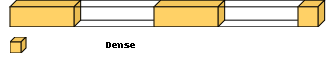

In [16]:
visualkeras.layered_view(model, legend=True, scale_z=1, scale_xy =20, spacing=80)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                768       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


### 5.2. Add callback

In [18]:
os.makedirs('./models', mode=0o750, exist_ok=True)
save_dir = "./models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3. Train it

In [19]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = fit_verbosity,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100
128/128 [==============================] - 1s 4ms/step - loss: 6.4846 - mae: 2.0340 - mse: 6.4846 - val_loss: 1.7913 - val_mae: 1.0380 - val_mse: 1.7913
Epoch 2/100
128/128 [==============================] - 0s 3ms/step - loss: 1.4978 - mae: 0.9614 - mse: 1.4978 - val_loss: 1.2237 - val_mae: 0.8902 - val_mse: 1.2237
Epoch 3/100
128/128 [==============================] - 0s 3ms/step - loss: 0.9971 - mae: 0.7901 - mse: 0.9971 - val_loss: 0.8215 - val_mae: 0.7179 - val_mse: 0.8215
Epoch 4/100
128/128 [==============================] - 0s 2ms/step - loss: 0.7490 - mae: 0.6833 - mse: 0.7490 - val_loss: 0.6153 - val_mae: 0.6042 - val_mse: 0.6153
Epoch 5/100
128/128 [==============================] - 0s 3ms/step - loss: 0.6290 - mae: 0.6191 - mse: 0.6290 - val_loss: 0.5270 - val_mae: 0.5615 - val_mse: 0.5270
Epoch 6/100
128/128 [==============================] - 0s 3ms/step - loss: 0.5401 - mae: 0.5718 - mse: 0.5401 - val_loss: 0.4751 - val_mae: 0.5467 - val_mse: 0.4751
Epoch 7/10

## 6. Evaluate
### 6.1. Model evaluation

**Mean Absolute Error (MAE)** is a metric used to evaluate the accuracy of a regression model. It measures the average absolute difference between the predicted values and the actual values. 

A MAE value of 3 indicates that, on average, the predictions deviate from the actual values by `$3k` (3.000 units of currency). In other words, the model's average prediction error is $3k.

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 0.5031
x_test / mae       : 0.5150
x_test / mse       : 0.5031


### 6.2. Training history

In [22]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 0.4655


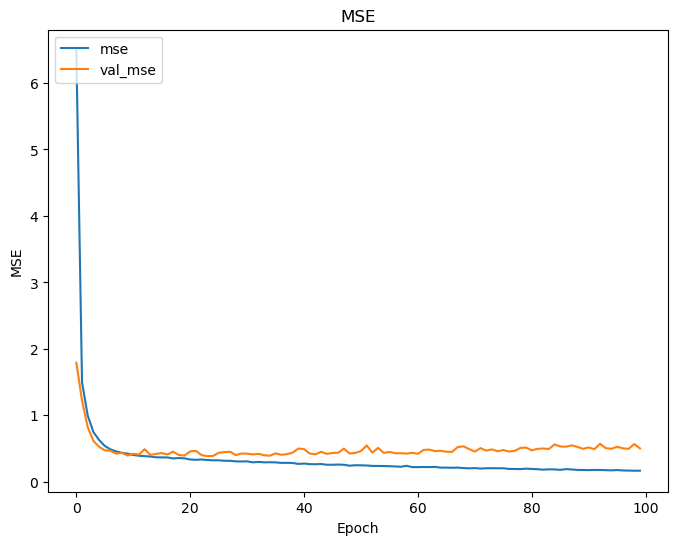

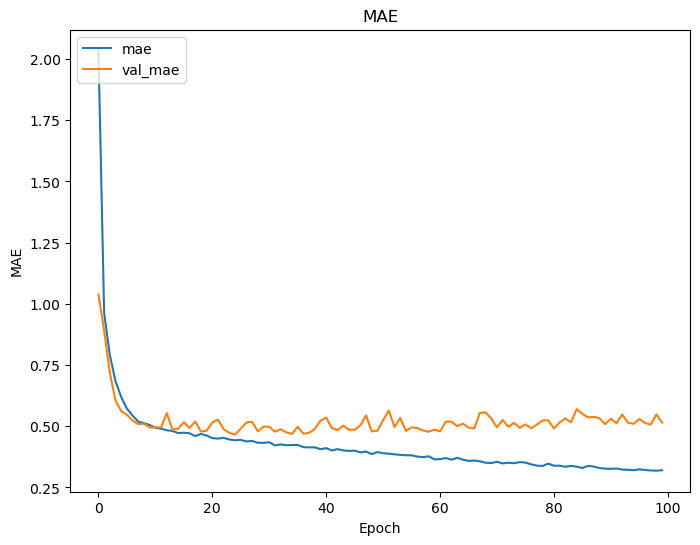

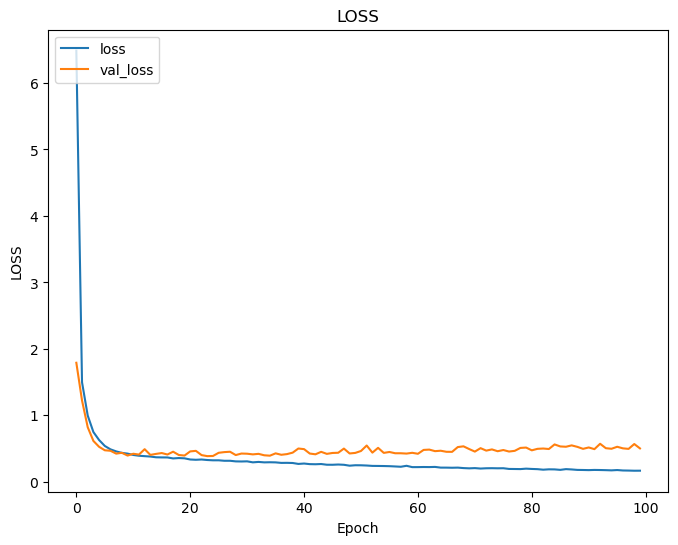

In [33]:
show_history( 
    history, 
    plot={
        'MSE' :['mse', 'val_mse'],
        'MAE' :['mae', 'val_mae'],
        'LOSS':['loss','val_loss']
    })

During our training, the best result achieved was a low training loss and a low validation loss. However, we observed that there was overfitting in the model.

Overfitting occurs when the model performs well on the training data but fails to generalize well to unseen data. It often results in a large gap between the training loss and the validation loss. In our case, we noticed that the model's performance on the training data was significantly better than its performance on the validation data, indicating overfitting.

During the training process, we implemented a callback mechanism to save the best-performing model. The callback monitored the validation loss during each epoch and automatically saved the model when it achieved the lowest validation loss.

By saving the best model, we ensured that we captured the model's parameters at the point where it exhibited the highest level of accuracy on the validation data. This allows us to use this saved model for future predictions or further analysis, confident that it represents the model with the best performance during the training process.

## 7. Evaluate the best model

### 7.1. Reload model

In [37]:
loaded_model = tf.keras.models.load_model('./models/best_model.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                768       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


### 7.2. Evaluate

In [39]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss : {:5.4f}'.format(score[0]))
print('x_test / mae : {:5.4f}'.format(score[1]))
print('x_test / mse : {:5.4f}'.format(score[2]))

x_test / loss : 0.3870
x_test / mae : 0.4728
x_test / mse : 0.3870


## 8. Make a prediction

In [27]:
# Pick n entries from our test set
n = 200
ii = np.random.randint(1,len(x_test),n)
x_sample = x_test[ii]
y_sample = y_test[ii]

In [28]:
# Make a predictions
y_pred = loaded_model.predict( x_sample, verbose=2 )

7/7 - 0s - 90ms/epoch - 13ms/step


In [36]:
# Show it
print('Wine    Prediction   Real   Delta')
for i in range(n):
    pred   = y_pred[i][0]
    real   = y_sample[i]
    delta  = real-pred
    print(f'{i:03d}        {pred:.2f}       {real}      {delta:+.2f} ')

Wine    Prediction   Real   Delta
000        4.94       5      +0.06 
001        5.29       5      -0.29 
002        5.40       5      -0.40 
003        5.08       5      -0.08 
004        5.20       6      +0.80 
005        5.55       6      +0.45 
006        5.43       5      -0.43 
007        4.40       5      +0.60 
008        5.77       6      +0.23 
009        5.49       6      +0.51 
010        6.54       6      -0.54 
011        4.94       5      +0.06 
012        5.23       6      +0.77 
013        5.14       5      -0.14 
014        4.96       5      +0.04 
015        5.77       6      +0.23 
016        4.73       5      +0.27 
017        6.67       7      +0.33 
018        5.18       5      -0.18 
019        5.18       5      -0.18 
020        5.13       5      -0.13 
021        5.54       5      -0.54 
022        5.12       5      -0.12 
023        5.37       6      +0.63 
024        5.18       5      -0.18 
025        5.14       5      -0.14 
026        5.00       5      -